どのような統計モデルでも利用可能な尤度比検定について説明する。これは逸脱度に注目する考え方で、ネストしているモデルたちを比較できる。

### 5.1 統計学的な検定の枠組み
単純モデルを帰無仮説、複雑モデルを対立仮説とする。

帰無仮説とは「棄却されるための仮説」であり、「無に帰される」時にのみ、その役割を果たす特殊な統計モデルという位置づけです。

統計モデルの検定の流れ。「帰無仮説は正しい」という命題を否定できるかどうか、その点だけを調べます。
- モデルの当てはまりの良さなどを検定統計量に指定する。
- 帰無仮説が「真のモデル」であると仮定して、その時に検定統計量の理論的なばらつき（確率分布）を調べて、検定統計量の値がとりうる「ありがちな範囲」を定める。
- この「ありがちな範囲」の大きさが95%である場合は、5%の有意水準を設定したと言います。
- 最後に対立仮説のモデルで得られた検定統計量が、この「ありがちな範囲」からはみ出ているかどうを確認し、もしはみでていれば帰無仮説は棄却され、対立仮説が支持されたと結論されます。

この検定の枠組みをNeyman-Pearsonの検定の枠組みと呼ぶ。

### 5.2尤度比検定の例題：逸脱度の差を調べる
ここでは、一定モデルと、ｘモデルを比較し、一定モデルが棄却できるかどうかを調べていく

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

In [2]:
data = pd.read_csv('data3a.csv')

In [3]:
data['f_int'] = (data.f == 'T').astype(int)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
y        100 non-null int64
x        100 non-null float64
f        100 non-null object
f_int    100 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [5]:
#フルモデル
llh = np.sum([stats.poisson.logpmf(data.y,data.y)])
deviance = -2*llh
residual_deviance = 0.0
AIC = -2*(llh - 100)
summary = [['full model',100,llh,deviance,residual_deviance,AIC]]

In [6]:
data.x_c = sm.add_constant(data.x)

In [7]:
#一定モデル
model1 = sm.GLM(data.y,data.x_c['const'],family=sm.families.Poisson())
result_1 = model1.fit()
summary.append(['const',result_1.df_model+1,result_1.llf,-2*result_1.llf,result_1.deviance,result_1.aic])
#xモデル
model2 = sm.GLM(data.y,data.x_c,family=sm.families.Poisson())
result_2 = model2.fit()
summary.append(['x model',result_2.df_model+1,result_2.llf,-2*result_2.llf,result_2.deviance,result_2.aic])

In [8]:
summary_frame = pd.DataFrame(summary,columns=['model','k','logL','deviance','resudual deviance','AIC'])

In [9]:
summary_frame.head()

,model,k,logL,deviance,resudual deviance,AIC
0,full model,100,-192.889753,385.779505,0.000000,585.779505
1,const,1,-237.643221,475.286443,89.506938,477.286443
2,x model,2,-235.386251,470.772502,84.992996,474.772502


xモデルと一定モデルの逸脱度の差は4.5位です。
尤度比とは以下の式で表せます。

$$\frac{L^{*}_{1}}{L^{*}_{2}} = \frac{max\ llh\ of\ const\ model}{max\ llh\ of\ x\ model} = \frac{exp(-237.6)}{exp(-235.4)}$$

尤度比は上式をそのまま用いず、尤度比の対数をとって-2をかけた値を用いいます。つまり、逸脱度の差を検定統計量として使います。
$$\Delta D_{1,2}=-2\times(logL^{*}_{1}-logL^{*}_{2})$$

逸脱度の差は4.5改善されていますが、ここでは「4.5くらいでは改善されていない」と言って良いのかどうかを調べます。

### 5.3 2種類の過誤と統計学的な検定の非対称性
- 帰無仮説が真のモデルである場合：データが一定モデルから生成されたのに「逸脱度の差が4.5もあるんだからxモデルのほうがよい、帰無仮説は正しくない」と判断する第一種の過誤
- 帰無仮説は真のモデルではない場合：データがxモデルから生成されたのに「逸脱度の差が4.5しかないんだからxモデルは意味もなく複雑、一定モデルで観測されたパターンで説明できるから帰無仮説は正しい。」

Neyman-Pearsonの検定の枠組みでは、第一種の過誤の検討にだけ専念する。

この例題の場合、実際の手順は以下の通り。

- 帰無仮説である一定モデルが正しいと仮定する
- 一定モデルのパラメータ=2.06は真のモデルとほぼ同じと考える。
- この真のモデルからデータを何度も生成して、そのたびに逸脱度の差を計算し、分布を作る。
- すると、逸脱度の差が$\Delta D_{1,2}=4.5$となるい確率Pが評価できる。

###  帰無仮説を棄却するための有意水準
上記のPの値は、「第一の過誤を犯す確率である。」

このPの値は自分で勝手に選ぶしかない。

### 5.4.1汎用性のあるパラメトリックブートストラップ法
いかなる面倒な状況でも必ずP値が計算できるパラメトリックブートストラップ法を説明する。

平均7.85のポアソン乱数を100個用意する

In [10]:
np.random.seed(10)
data['y_rand'] = np.random.poisson(data.y.mean(),100)
result_1 = sm.GLM(data.y_rand,data.x_c['const'],family=sm.families.Poisson()).fit()
result_2 = sm.GLM(data.y_rand,data.x_c,family=sm.families.Poisson()).fit()
deltaD = result_1.deviance - result_2.deviance
print deltaD

2.70683378851


このように、体サイズxとなんの関係もなし、平均値一定のポアソン乱数であるデータに対しても、逸脱度の差が2.7となりました。「真のモデル」である一定モデルよりも、無意味な説明変数をもつxモデルのほうが当てはまりが良くなります。
このようにして、「一定モデルが真のモデルある世界」での逸脱度の差がひとつ得られます。これはPB（パラメトリックブートストラップ法）の１スッテプであり、このステップを1000回ほど繰り返すと「検定統計量の分布」を予測できます。

In [11]:
def get_dd(data):
    data['y_rand'] = np.random.poisson(data.y.mean(),100)
    result = sm.GLM(data.y_rand,data.x_c,family=sm.families.Poisson()).fit()
    return result.null_deviance - result.deviance

def pb(data,n_bootstrap):
    return np.array([get_dd(data) for i in range(n_bootstrap)])

dd12 = pb(data,10000)

In [12]:
dd12 = pd.Series(dd12)
print dd12.describe()

count    1.000000e+04
mean     9.899338e-01
std      1.391963e+00
min      8.018162e-09
25%      1.054329e-01
50%      4.667647e-01
75%      1.314633e+00
max      1.935826e+01
dtype: float64


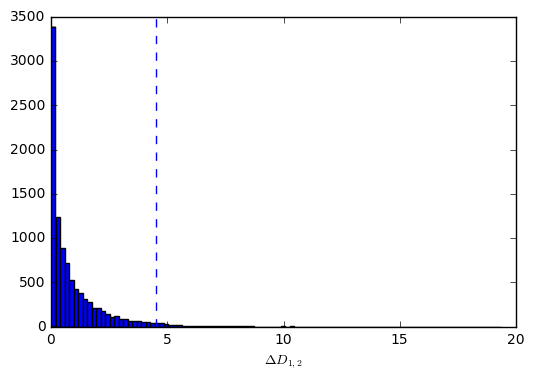

In [13]:
plt.hist(dd12,bins=100)
plt.xlabel('$\Delta D_{1,2}$')
plt.axvline(x=4.5,linestyle='--')
plt.show()

In [14]:
(dd12 >= 4.5).sum()

324

よって1000個中324個が4.5より大きいことがわかりました。つまり、P=0.032

P=0.05となる逸脱度の差をしらべると・・・

In [15]:
dd12.quantile(0.95)

3.8103364321454825

有意水準5%の統計学検定の枠組みの基では$\Delta D_{1,2}\leq3.8$のぐらいまでは良くある差とみなされる。

### 5.4.2χ二乗分布を使った近似計算

逸脱度の差$\Delta D_{1,2}$は自由度１のχ二乗分布で近似できる場合がある。

In [20]:
P = stats.chi2.sf(x=4.5,df=1)

In [21]:
P

0.033894853524689295

逸脱度の差が4.5になる確率は0.034とない、帰無仮説は棄却されます。なお、カイ二乗分布近似はサンプルサイズが大きい場合に有効な近似計算であることに注意。

## 5.5「帰無仮説を棄却できない」は「差がない」ではない。
仮に$P\geq0.05$となった場合、どのように結論つけるのであろう。答えは、「帰無仮説」は棄却できないとする。
そして、この意味は帰無仮説・対立仮説のどちらも正しいとも正しくないともいえない、つまり判断を保留するということである。

## 5.6検定とモデル選択、そして推定された統計モデルの解釈
尤度比検定、AICはどちらも、逸脱度（あるいは、最大対数尤度）という統計量に注目しているが、目的とするところが全く異なる。

尤度比検定などNeyman-Pearsonの枠組みのもとでの統計学的な検定の目的は、帰無仮説の安全な棄却です。